# Epidemic Modeling with Epydemix

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/epistorm/tech-transfer-epydemix/blob/main/sessions/session-3/python/01_modeling_tutorial.ipynb)

This tutorial walks through building an age-structured SEIR model, running simulations with real population data, and comparing intervention scenarios.

**What you'll learn:**
- Define compartmental models and transitions from scratch
- Load population data and contact matrices for 400+ geographies
- Run stochastic simulations and visualize results
- Model non-pharmaceutical interventions and compare scenarios
- Simulate vaccination campaigns

In [ ]:
# Colab installation (skip if running locally)
import sys, os, subprocess
if "google.colab" in sys.modules or os.getenv("COLAB_RELEASE_TAG"):
    subprocess.run([
        sys.executable, "-m", "pip", "install", "-q", "-r",
        "https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/colab_requirements.txt"
    ])

---
## 1. Building an SEIR Model from Scratch

Compartmental models divide the population into states. The **SEIR model** has four:

- **S** (Susceptible): Can be infected
- **E** (Exposed): Infected but not yet infectious (latent period)
- **I** (Infectious): Can transmit the disease
- **R** (Recovered): Immune

Transitions between compartments are either:
- **Mediated**: Depends on interactions (S→E requires contact with I)
- **Spontaneous**: Happens at a fixed rate (E→I, I→R)

In [4]:
from epydemix import EpiModel

# Create the model with four compartments
model = EpiModel(
    name="SEIR Model",
    compartments=["S", "E", "I", "R"]
)

# Add transitions
# S --> E: mediated by contact with infectious individuals (rate \beta)
model.add_transition(
    source="S", target="E",
    params=("beta", "I"),
    kind="mediated"
)

# E --> I: spontaneous at rate \sigma (1/latent period)
model.add_transition(
    source="E", target="I",
    params="sigma",
    kind="spontaneous"
)

# I --> R: spontaneous at rate \gamma (1/infectious period)
model.add_transition(
    source="I", target="R",
    params="gamma",
    kind="spontaneous"
)

# Set parameter values
model.add_parameter("beta", 0.035)   # transmission rate
model.add_parameter("sigma", 0.2)   # 1/5 days latent period
model.add_parameter("gamma", 0.1)   # 1/10 days infectious period

print(model)

EpiModel(name='SEIR Model')
Compartments: 4
  S, E, I, R
Transitions: 3
  Transitions between compartments:
    S -> E, params: ('beta', 'I') (kind: mediated)
    E -> I, params: sigma (kind: spontaneous)
    I -> R, params: gamma (kind: spontaneous)
Parameters: 3
  Model parameters:
    beta: 0.035
    sigma: 0.2
    gamma: 0.1
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



---
## 2. Loading Population Data

Epydemix includes demographic data and synthetic contact matrices for 400+ regions worldwide. Let's load data for **United States**.

The `Population` object contains:
- **Population distribution** by age group
- **Contact matrices** for different settings (home, school, work, community)

You can see all supported locations [here](https://github.com/epistorm/epydemix-data/blob/main/locations.csv).

In [5]:
from epydemix.population import load_epydemix_population

# Load US population data
population = load_epydemix_population("United_States")
print(population)

Population(name='United_States')
Demographic groups: 5 groups
Population distribution:
  - 0-4: 18608139 individuals
  - 5-19: 63540783 individuals
  - 20-49: 132780169 individuals
  - 50-64: 63172279 individuals
  - 65+: 60019216 individuals
Contact matrices: 4 layers
Available layers:
  - school
  - work
  - home
  - community



Let's attach the population to our model before moving on.

In [6]:
model.set_population(population)

### Exploring the Population

Let's visualize the age distribution and contact patterns.

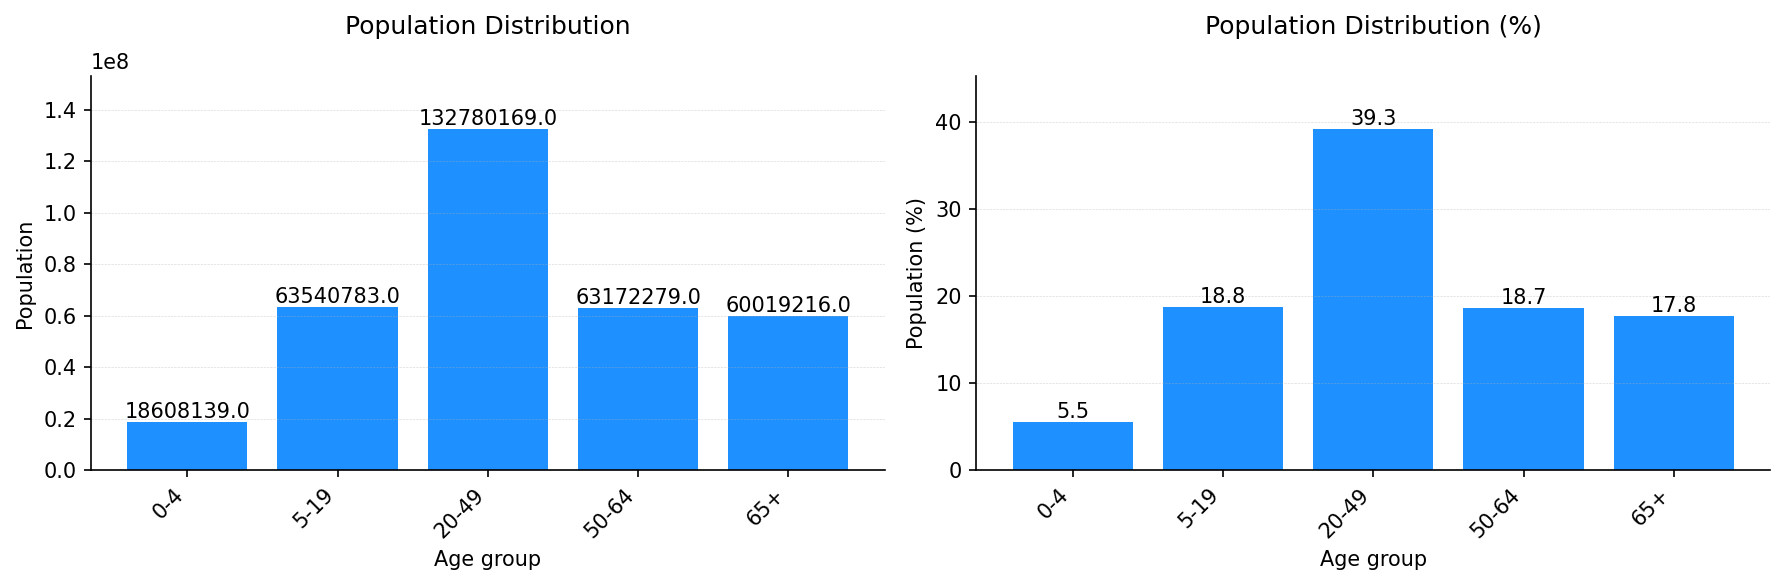

In [7]:
from epydemix.visualization import plot_contact_matrix, plot_population
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=150)

# Population pyramid
plot_population(population, ax=axes[0], title="Population Distribution")

# Population percentages
plot_population(population, ax=axes[1], title="Population Distribution (%)", show_perc=True)

plt.tight_layout()

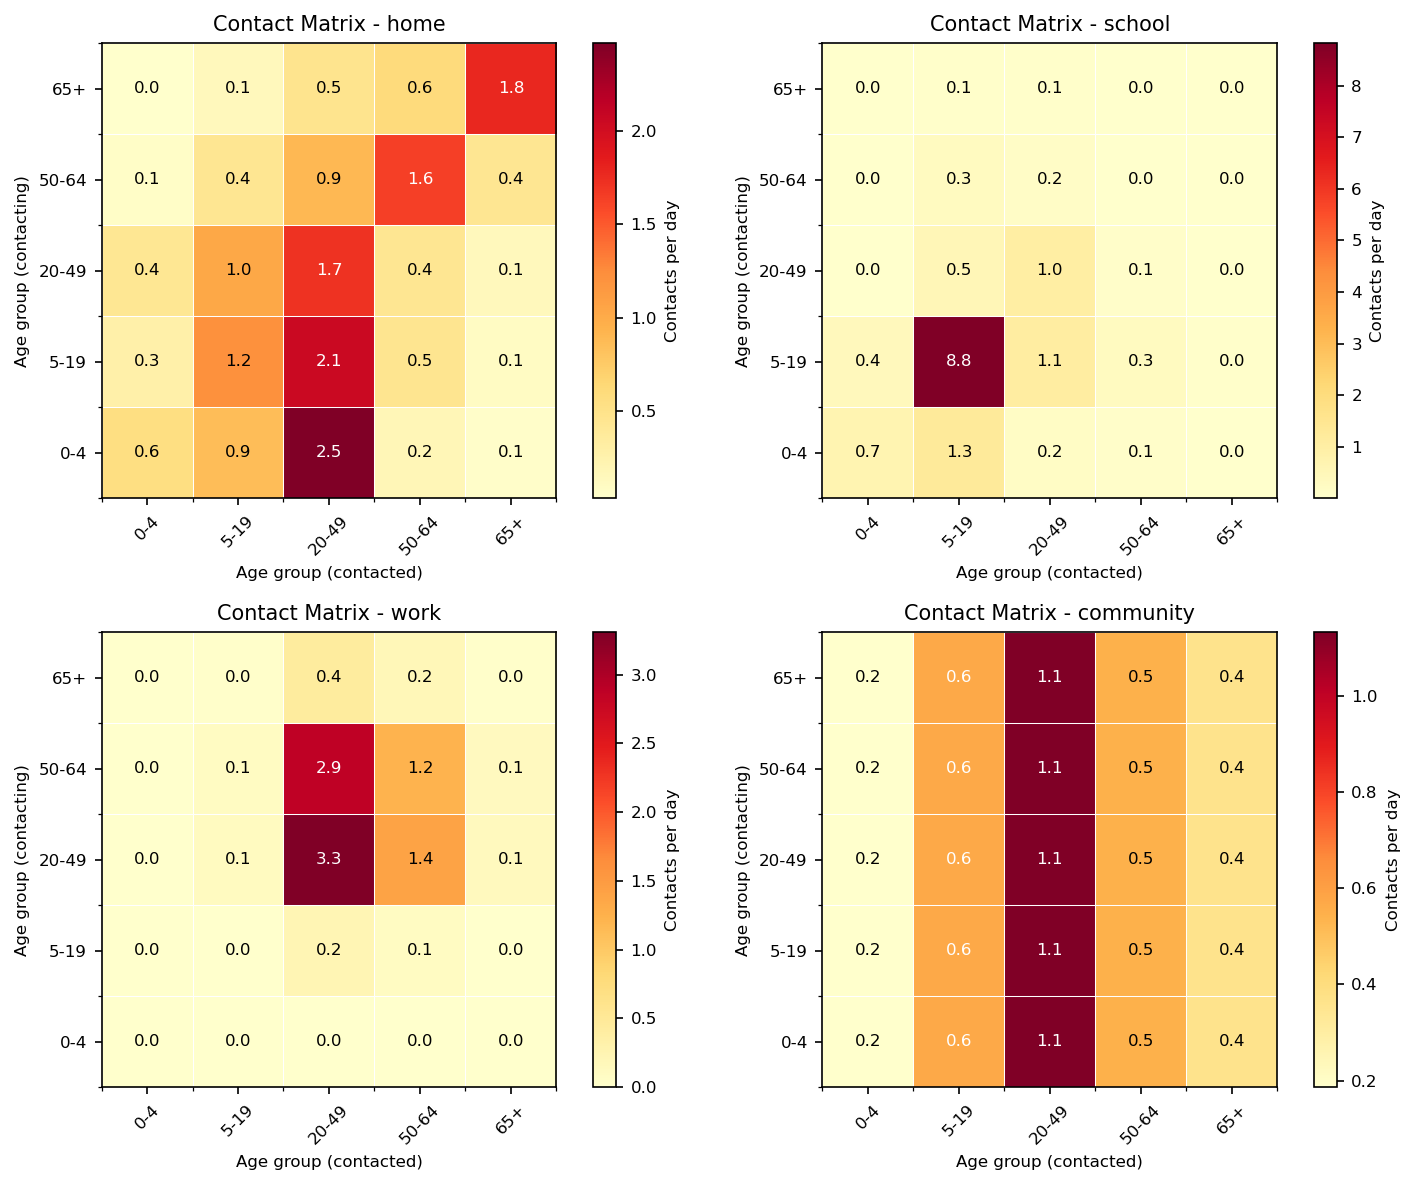

In [8]:
# Contact matrices by setting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), dpi=150)

for ax, layer in zip(axes.flatten(), ["home", "school", "work", "community"]):
    plot_contact_matrix(population, layer, ax=ax, fontsize=8, show_values=True)

plt.tight_layout()

**Reading contact matrices:** Each cell $(i, j)$ shows the average daily contacts that a person in age group $i$ has with people in age group $j$. Notice how:
- **School** contacts are concentrated among children (5-19)
- **Work** contacts peak in working-age adults (20-64)
- **Home** contacts show intergenerational mixing
- **Community** contacts are more diffuse

### What is the Model $R_0$?

The reproduction number $R_0$ is the average number of people an infected person will infect. For the SEIR model on an age-structured population, it can be computed as:    

$$
R_0 = \frac{\beta}{\gamma} \rho(C)
$$

Where $\rho(C)$ is the spectral radius (i.e., the largest eigenvalue) of the contact matrix $C$, $\beta$ is the transmission rate, and $\gamma$ is the recovery rate. The spectral radius is a measure of the "intensity" of contacts in the population: higher values mean that there are more contacts, and therefore more opportunities for transmission. In other words, $R_0$ is the product of the average number of people an infected person will infect per unit of time and the average duration of the infectious period. In our case, $R_0$ can be computed as:




In [9]:
import numpy as np

# Get overall contact matrix as sum of individual matrices and compute spectral radius
C = np.sum(list(model.population.contact_matrices.values()), axis=0)
rho = np.linalg.eigvals(C).real.max()  

# Compute R0
R0 = model.parameters["beta"] / model.parameters["gamma"] * rho
print(f"R0: {R0:.2f}")

R0: 4.91


---
## 3. Running Simulations

Epydemix uses **stochastic chain-binomial** simulations. Each run produces a different trajectory due to randomness—we run many simulations to capture uncertainty.

Let's run simulations.

In [10]:
# Run 100 stochastic simulations
results = model.run_simulations(
    start_date="2026-01-01",
    end_date="2026-08-31",
    Nsim=25,
    percentage_in_agents=10 / population.Nk.sum()  # seed with 10 infected
)

### Visualizing Results

The `SimulationResults` object provides methods to extract compartment counts and transitions over time.

<Axes: title={'center': 'SEIR Epidemic Trajectory'}>

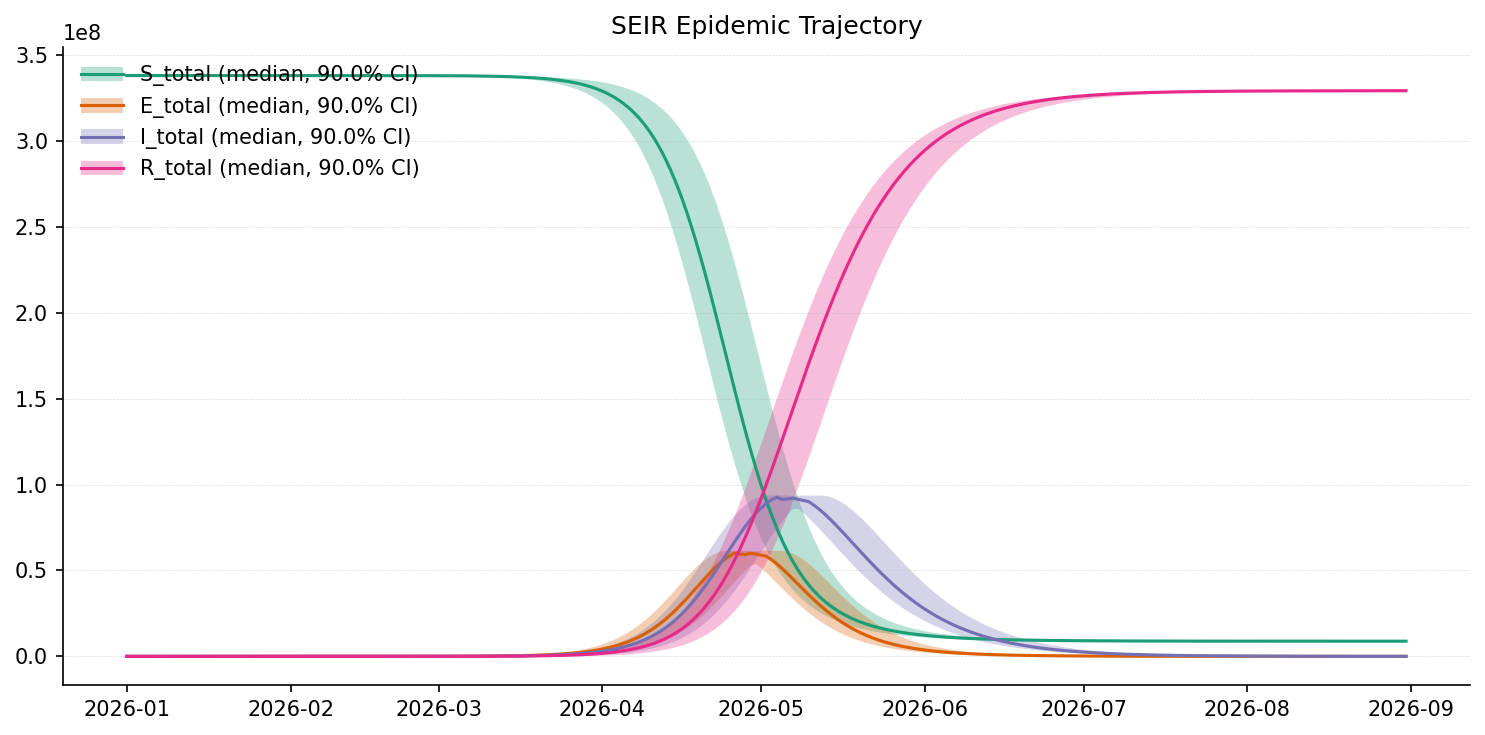

In [11]:
from epydemix.visualization import plot_quantiles

# Get quantiles (median, 25th, 75th percentiles) across simulations
df_quantiles = results.get_quantiles_compartments()

# Plot all compartments
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_quantiles(df_quantiles, columns=["S_total", "E_total", "I_total", "R_total"], 
               title="SEIR Epidemic Trajectory", ax=ax)

<Axes: title={'center': 'Infections by Age Group'}>

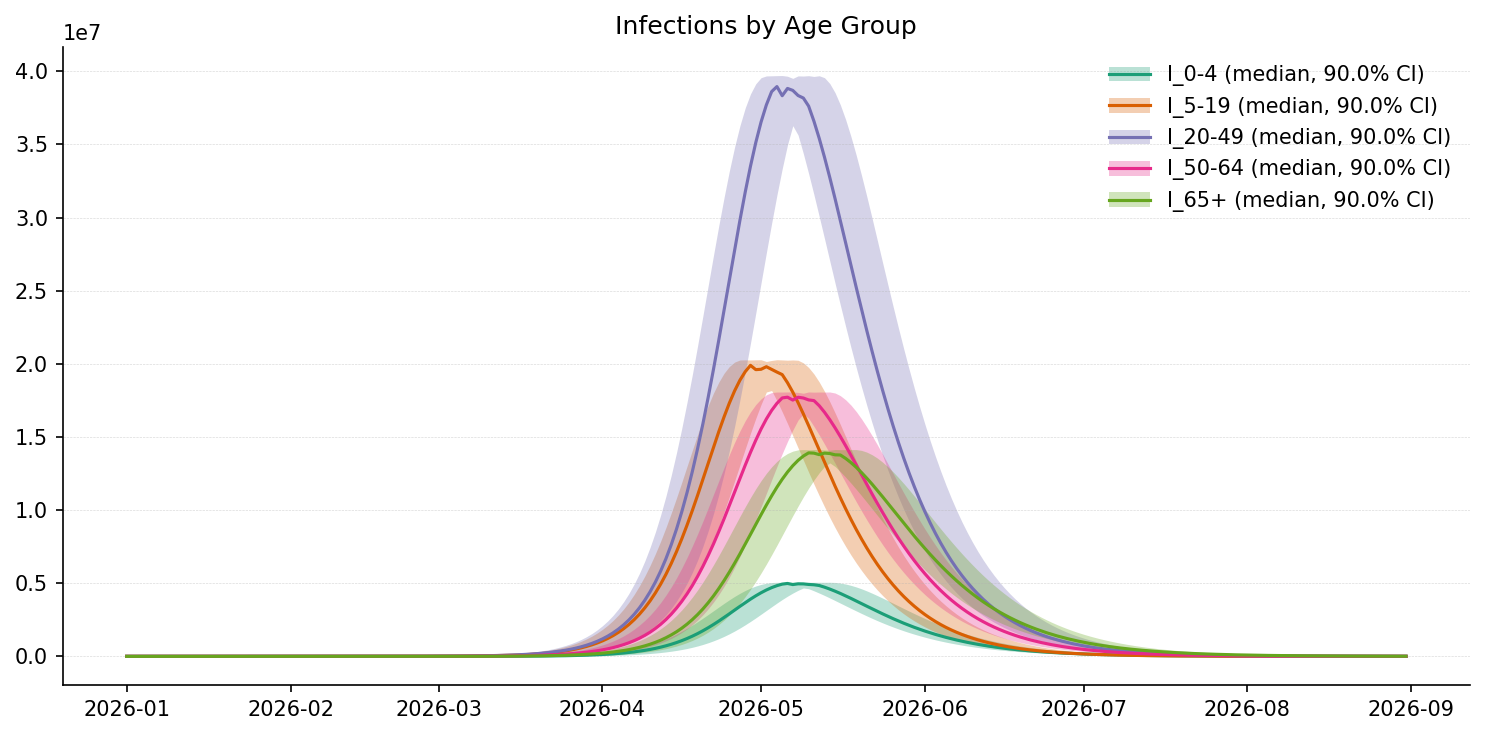

In [12]:
# Infections by age group
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_quantiles(df_quantiles, 
               columns=["I_0-4", "I_5-19", "I_20-49", "I_50-64", "I_65+"],
               title="Infections by Age Group", ax=ax, legend_loc="upper right")

<Axes: title={'center': 'Individual Simulation Trajectories (Infected)'}>

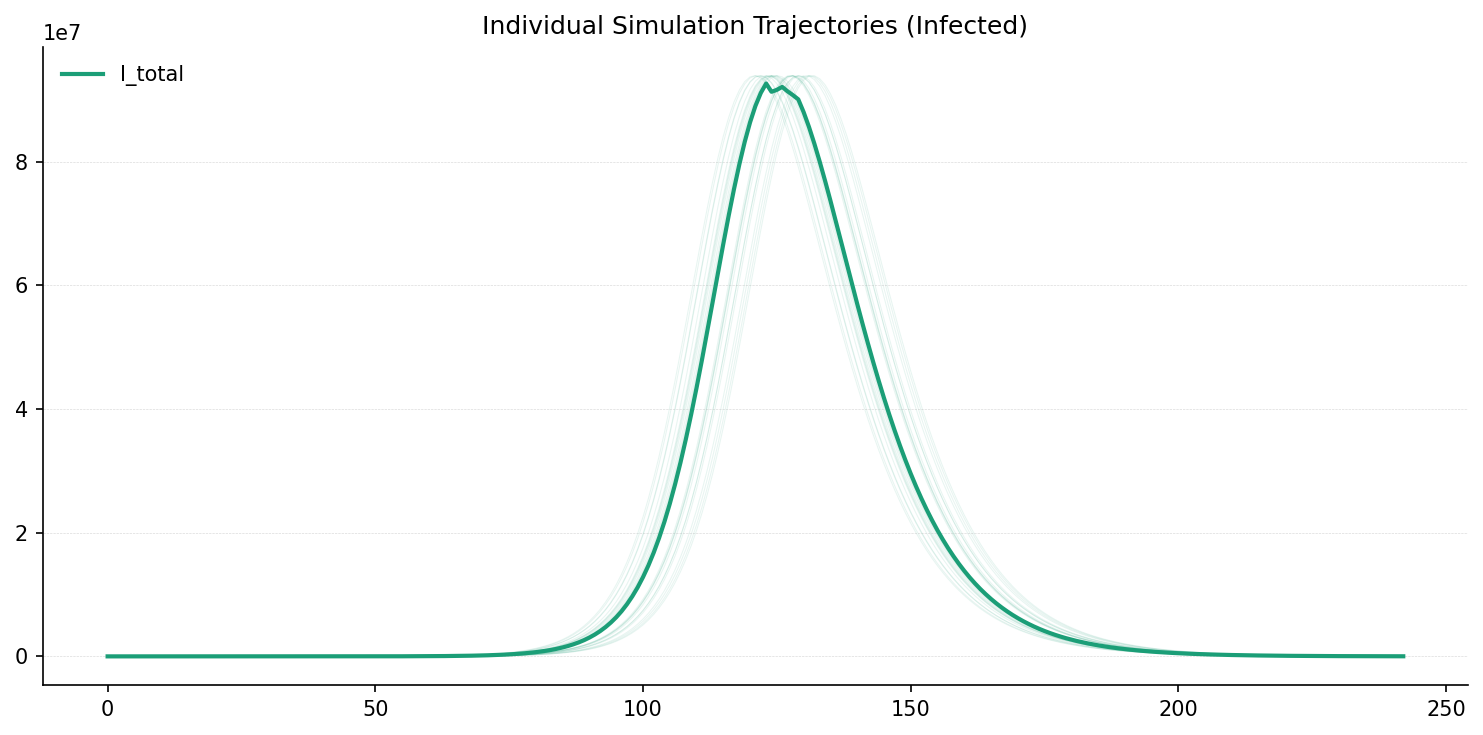

In [13]:
from epydemix.visualization import plot_trajectories

# Show individual simulation trajectories
trajectories = results.get_stacked_compartments()
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_trajectories(trajectories, columns=["I_total"], 
                  title="Individual Simulation Trajectories (Infected)", ax=ax)

Let's see what the data looks like underneath all this

In [15]:
df_quantiles.head()

,date,quantile,S_0-4,S_5-19,S_20-49,S_50-64,S_65+,S_total,E_0-4,E_5-19,...,I_20-49,I_50-64,I_65+,I_total,R_0-4,R_5-19,R_20-49,R_50-64,R_65+,R_total
0,2026-01-01,0.025,18608138.0,63540779.6,132780162.6,63172276.0,60019214.0,338120573.6,0.0,0.0,...,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2026-01-02,0.025,18608138.0,63540778.0,132780160.6,63172275.6,60019214.0,338120570.6,0.0,0.0,...,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2026-01-03,0.025,18608138.0,63540776.6,132780157.6,63172274.6,60019212.6,338120566.6,0.0,0.0,...,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2026-01-04,0.025,18608138.0,63540775.0,132780157.0,63172273.6,60019212.0,338120564.2,0.0,0.0,...,2.0,0.0,0.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0
4,2026-01-05,0.025,18608137.0,63540773.0,132780155.6,63172271.6,60019211.0,338120556.4,0.0,0.6,...,1.6,0.0,0.0,4.6,0.0,0.0,0.0,0.0,0.0,0.6


In [17]:
df_quantiles['quantile'].unique()

array([0.025, 0.05 , 0.25 , 0.5  , 0.75 , 0.95 , 0.975])

In [28]:
type(results)

epydemix.model.simulation_results.SimulationResults

[Docs for this data type](https://epydemix.readthedocs.io/en/latest/epydemix.model.html#epydemix.model.simulation_results.SimulationResults) ^^^

---
## 4. Modeling Interventions

Non-pharmaceutical interventions (NPIs) reduce transmission by limiting contacts. Epydemix supports two approaches:

1. **`add_intervention`**: Reduce contacts in specific settings (school closure, work-from-home)
2. **`override_parameter`**: Modify transmission parameters directly (masking, social distancing)

Let's compare a baseline scenario to one with interventions.

In [14]:
# Create three identical SEIR models for comparison
def create_seir_model():
    m = EpiModel(name="SEIR", compartments=["S", "E", "I", "R"])
    m.add_transition(source="S", target="E", params=("beta", "I"), kind="mediated")
    m.add_transition(source="E", target="I", params="sigma", kind="spontaneous")
    m.add_transition(source="I", target="R", params="gamma", kind="spontaneous")
    m.add_parameter("beta", 0.035)
    m.add_parameter("sigma", 0.2)
    m.add_parameter("gamma", 0.1)
    m.set_population(population)
    return m

model_baseline = create_seir_model()
model_contact_intervention = create_seir_model()
model_transmission_intervention = create_seir_model()

In [18]:
# Model 2: Contact interventions (school closure + work-from-home)

# School closure: 70% reduction in school contacts (Apr 1 - Aug 31)
model_contact_intervention.add_intervention(
    layer_name="school",
    start_date="2026-04-01",
    end_date="2026-08-31",
    reduction_factor=0.3,  # 70% reduction
    name="school closure"
)

# Work-from-home: 50% reduction in work contacts (Apr 1 - Aug 31)
model_contact_intervention.add_intervention(
    layer_name="work",
    start_date="2026-04-01",
    end_date="2026-08-31",
    reduction_factor=0.5,  # 50% reduction
    name="work from home"
)

# Model 3: Transmission reduction (e.g., masking, social distancing)
# Reduces beta by ~30% during the intervention period
model_transmission_intervention.override_parameter(
    start_date="2026-04-01",
    end_date="2026-08-31",
    parameter_name="beta",
    value=0.025  # reduced from 0.035
)

### Visualizing Intervention Impact on Contacts

The **spectral radius** of the contact matrix is proportional to $R_0$. We can visualize how interventions reduce it over time.

Text(0.5, 1.0, 'Contact Intervention: Change in Spectral Radius')

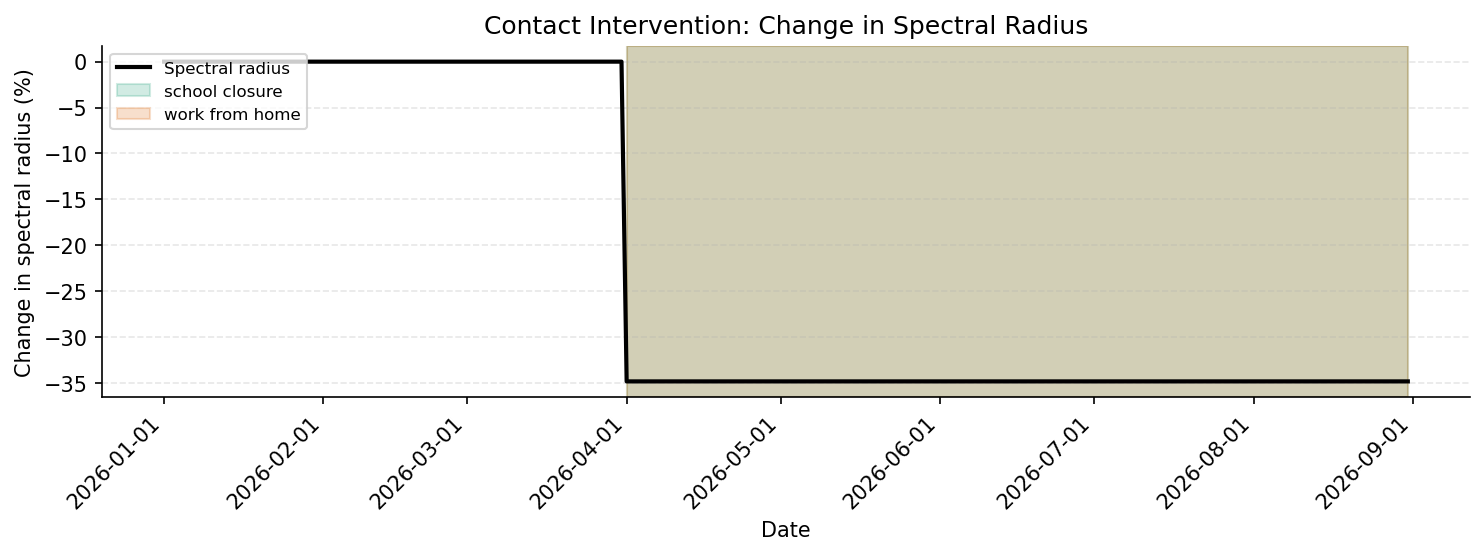

In [19]:
from epydemix.visualization import plot_spectral_radius
from epydemix.utils import compute_simulation_dates

# Compute contact reductions for visualization
simulation_dates = compute_simulation_dates("2026-01-01", "2026-08-31")
model_contact_intervention.compute_contact_reductions(simulation_dates)

# Plot spectral radius change
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
plot_spectral_radius(model_contact_intervention, show_perc=True, ax=ax)
ax.set_title("Contact Intervention: Change in Spectral Radius")

### Comparing Scenarios

In [20]:
# Run all three scenarios
sim_params = dict(
    start_date="2026-01-01",
    end_date="2026-08-31",
    Nsim=25,
    percentage_in_agents=10 / population.Nk.sum()
)

results_baseline = model_baseline.run_simulations(**sim_params)
results_contact = model_contact_intervention.run_simulations(**sim_params)
results_transmission = model_transmission_intervention.run_simulations(**sim_params)

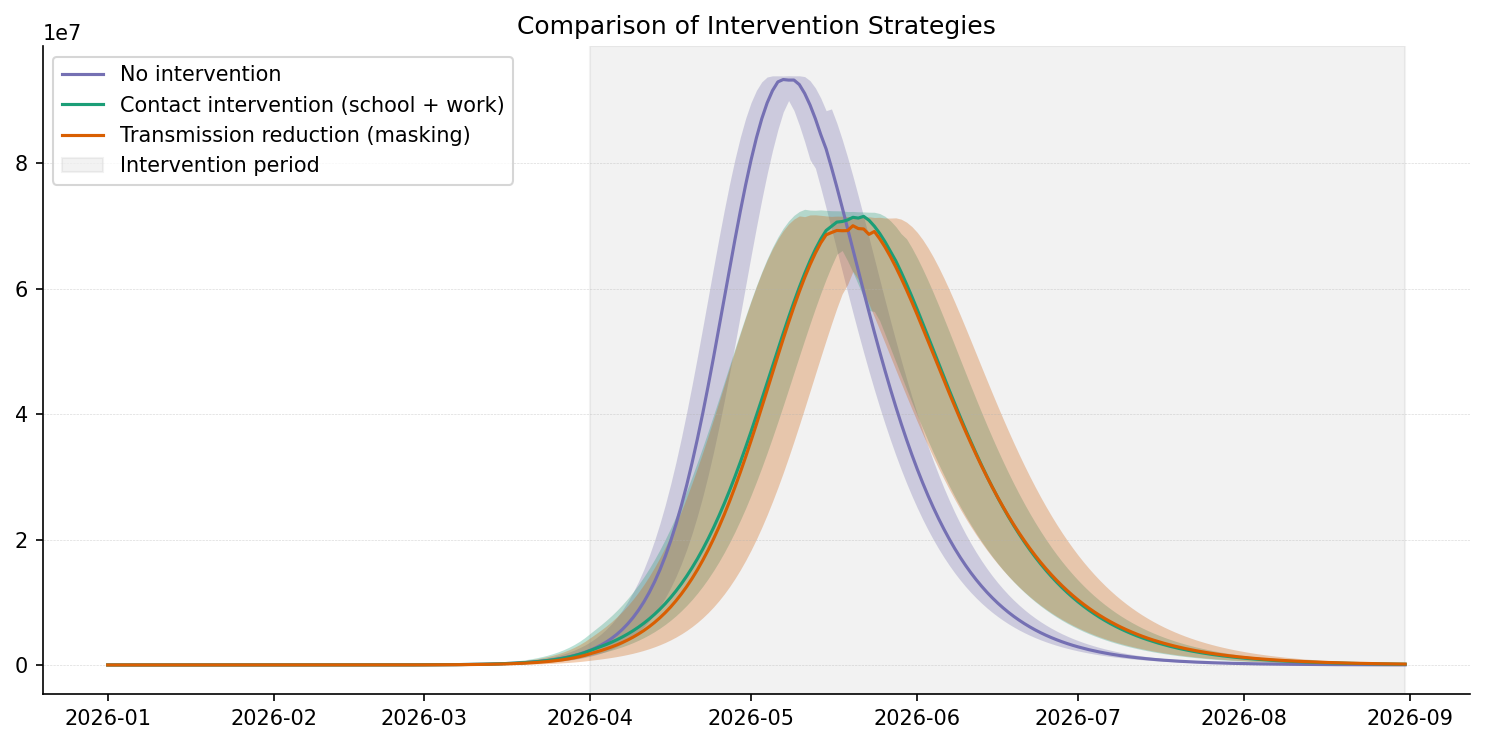

In [ ]:
import seaborn as sns
colors = sns.color_palette("Dark2")

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)

# Plot baseline
df_baseline = results_baseline.get_quantiles_compartments()
plot_quantiles(df_baseline, columns=["I_total"], colors=colors[2], 
               labels="No intervention", ax=ax)

# Plot contact intervention scenario
df_contact = results_contact.get_quantiles_compartments()
plot_quantiles(df_contact, columns=["I_total"], colors=colors[0],
               labels="Contact intervention (school + work)", ax=ax)

# Plot transmission intervention scenario
df_transmission = results_transmission.get_quantiles_compartments()
plot_quantiles(df_transmission, columns=["I_total"], colors=colors[1],
               labels="Transmission reduction (masking)", ax=ax)

ax.set_title("Comparison of Intervention Strategies")
ax.axvspan(
    "2026-04-01", "2026-08-31",
    alpha=0.1, color="gray",
    label="Intervention period"
)
ax.legend()

### Quantifying Impact

Let's calculate the reduction in total infections and peak size.

In [31]:
import numpy as np

# Get full trajectories
traj_baseline = results_baseline.get_stacked_compartments()
traj_contact = results_contact.get_stacked_compartments()
traj_transmission = results_transmission.get_stacked_compartments()

# Total infections (final recovered count)
total_baseline = traj_baseline["R_total"][:, -1]
total_contact = traj_contact["R_total"][:, -1]
total_transmission = traj_transmission["R_total"][:, -1]

averted_contact = (total_baseline - total_contact) / total_baseline * 100
averted_transmission = (total_baseline - total_transmission) / total_baseline * 100

# Peak infections
peak_baseline = traj_baseline["I_total"].max(axis=1)
peak_contact = traj_contact["I_total"].max(axis=1)
peak_transmission = traj_transmission["I_total"].max(axis=1)

peak_reduction_contact = (peak_baseline - peak_contact) / peak_baseline * 100
peak_reduction_transmission = (peak_baseline - peak_transmission) / peak_baseline * 100

print("Contact intervention (school + work):")
print(f"  Infections averted: {np.median(averted_contact):.1f}% (IQR: {np.percentile(averted_contact, 25):.1f}–{np.percentile(averted_contact, 75):.1f}%)")
print(f"  Peak reduction: {np.median(peak_reduction_contact):.1f}% (IQR: {np.percentile(peak_reduction_contact, 25):.1f}–{np.percentile(peak_reduction_contact, 75):.1f}%)")
print()
print("Transmission reduction (masking):")
print(f"  Infections averted: {np.median(averted_transmission):.1f}% (IQR: {np.percentile(averted_transmission, 25):.1f}–{np.percentile(averted_transmission, 75):.1f}%)")
print(f"  Peak reduction: {np.median(peak_reduction_transmission):.1f}% (IQR: {np.percentile(peak_reduction_transmission, 25):.1f}–{np.percentile(peak_reduction_transmission, 75):.1f}%)")

Contact intervention (school + work):
  Infections averted: 2.8% (IQR: 2.8–2.8%)
  Peak reduction: 23.0% (IQR: 22.9–23.1%)

Transmission reduction (masking):
  Infections averted: 4.7% (IQR: 4.6–4.7%)
  Peak reduction: 23.8% (IQR: 23.7–23.9%)


---
## 5. Modeling Vaccination Campaigns

Vaccination is a key intervention strategy. In Epydemix, we can model vaccination by:
1. Adding a **vaccinated compartment** (e.g., `SV` for vaccinated susceptibles)
2. Defining a **spontaneous transition** that moves individuals from `S` to `SV` at a fixed vaccination rate
3. Reducing transmission for vaccinated individuals based on **vaccine effectiveness (VE)**

Let's build an SIR model with vaccination.

### Building the Model with Vaccination

We create an SIR model with an additional `SV` (vaccinated susceptible) compartment. Susceptibles are vaccinated at a constant rate `vax_rate`, and vaccinated individuals have reduced susceptibility based on vaccine effectiveness (VE).

In [32]:
# Create model with vaccination compartment
model_vax = EpiModel(name="SIR with Vaccination", compartments=["S", "SV", "I", "R"])

# S + I → I (unvaccinated infection)
model_vax.add_transition("S", "I", params=("beta", "I"), kind="mediated")

# SV + I → I (vaccinated infection, reduced by VE)
model_vax.add_transition("SV", "I", params=("(1 - VE) * beta", "I"), kind="mediated")

# S → SV (vaccination at constant rate)
model_vax.add_transition("S", "SV", params="vax_rate", kind="spontaneous")

# I → R (recovery)
model_vax.add_transition("I", "R", params="gamma", kind="spontaneous")

# Set parameters
model_vax.add_parameter("beta", 0.02)
model_vax.add_parameter("gamma", 0.1)
model_vax.add_parameter("VE", 0.7)        # 70% vaccine effectiveness
model_vax.add_parameter("vax_rate", 0.005) # ~0.5% of susceptibles vaccinated per day

# Use North Carolina population 
pop_nc = load_epydemix_population("United_States_North_Carolina")
model_vax.set_population(pop_nc)

print(model_vax)

EpiModel(name='SIR with Vaccination')
Compartments: 4
  S, SV, I, R
Transitions: 4
  Transitions between compartments:
    S -> I, params: ('beta', 'I') (kind: mediated)
    SV -> I, params: ('(1 - VE) * beta', 'I') (kind: mediated)
    S -> SV, params: vax_rate (kind: spontaneous)
    I -> R, params: gamma (kind: spontaneous)
Parameters: 4
  Model parameters:
    beta: 0.02
    gamma: 0.1
    VE: 0.7
    vax_rate: 0.005
Population: United_States_North_Carolina
  Population size: 10835491 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+



### Running the Vaccination Simulation

In [33]:
# Run vaccination simulation
results_vax = model_vax.run_simulations(
    start_date="2026-01-01",
    end_date="2026-06-30",
    Nsim=25,
    initial_conditions_dict={
        "S": model_vax.population.Nk - np.ones(5)*10, 
        "I": np.ones(5)*10,
        "SV": np.zeros(5), 
        "R": np.zeros(5)}
)

<Axes: title={'center': 'SIR Model with Vaccination Campaign'}>

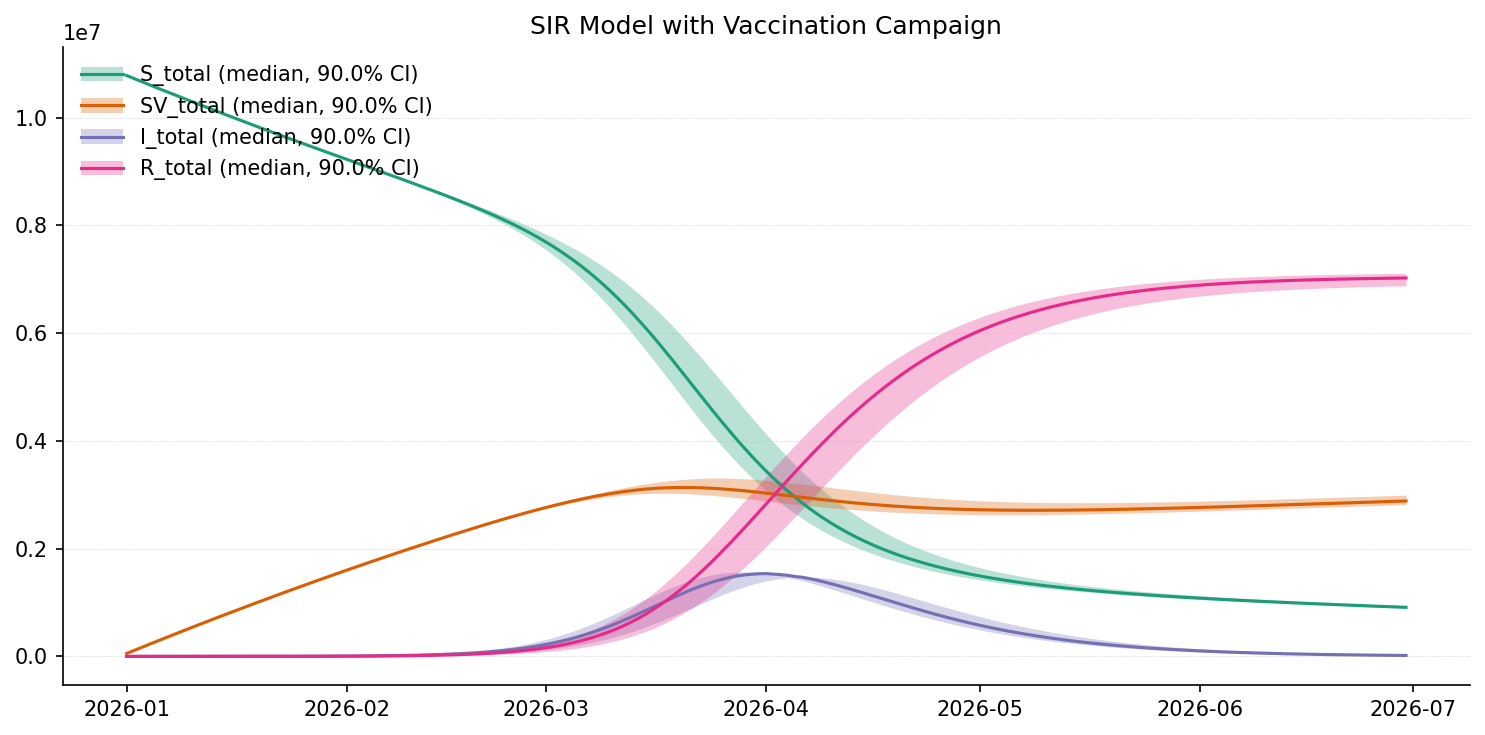

In [34]:
# Plot compartment evolution
df_vax_quantiles = results_vax.get_quantiles_compartments()

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_quantiles(df_vax_quantiles, 
               columns=["S_total", "SV_total", "I_total", "R_total"],
               title="SIR Model with Vaccination Campaign", ax=ax)

<Axes: title={'center': 'Vaccinated Susceptibles by Age Group'}>

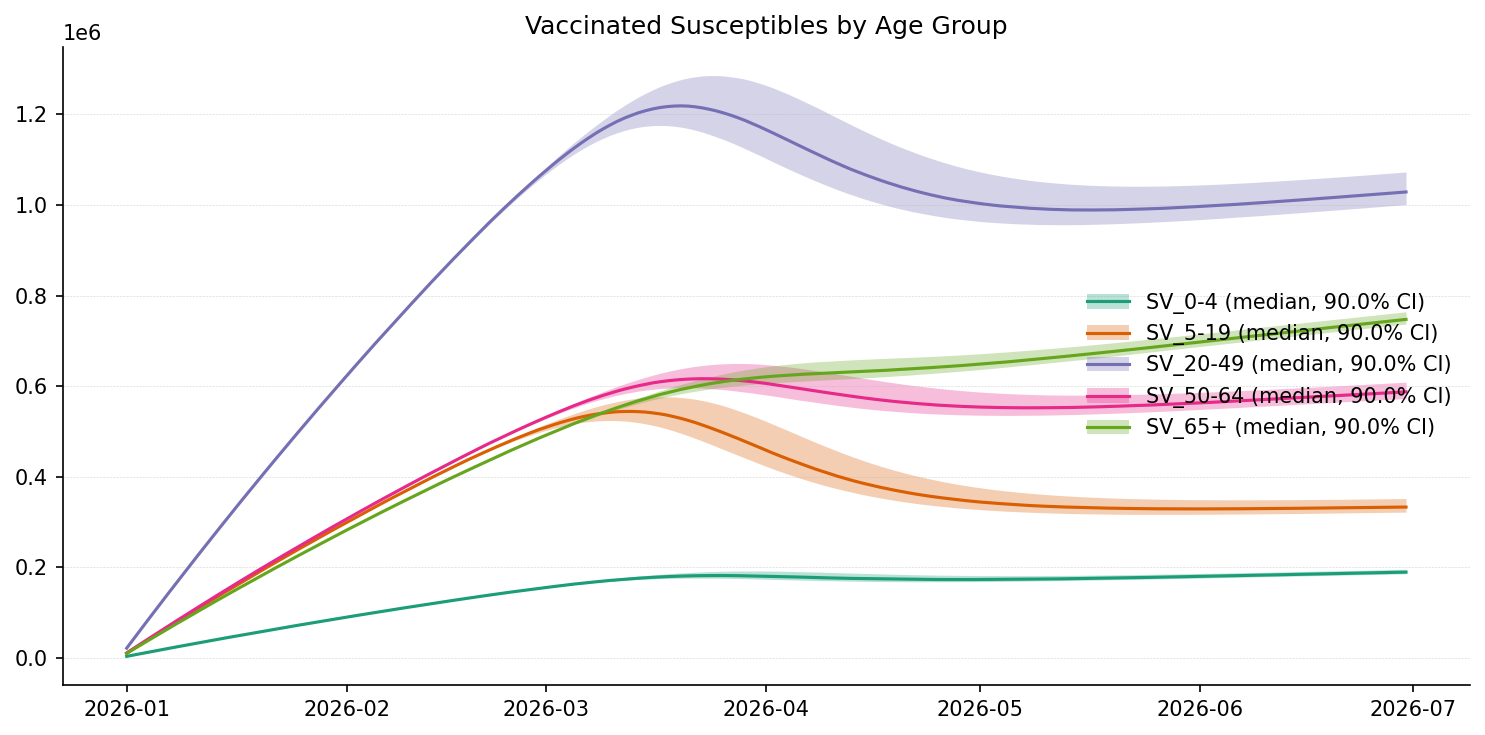

In [35]:
# Vaccinated individuals by age group
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_quantiles(df_vax_quantiles,
               columns=["SV_0-4", "SV_5-19", "SV_20-49", "SV_50-64", "SV_65+"],
               title="Vaccinated Susceptibles by Age Group", ax=ax, legend_loc="center right")

### Nicolo's recs for tutorials

Check out the [Epydemix GitHub repo](https://github.com/epistorm/epydemix) for [more tutorials](https://github.com/epistorm/epydemix/tree/main/tutorials) that work along these lines!

- [Advanced modeling features](https://github.com/epistorm/epydemix/blob/main/tutorials/06_Advanced_Modeling_Features.ipynb)

### Limitations and Extensions

The constant-rate vaccination model above is a simplification. In reality, vaccination campaigns have variable uptake over time and across age groups. Two possible extensions are:

1. **Time- and age-dependent vaccination rates.** You can make `vax_rate` change over time to model a ramp-up phase followed by steady-state capacity, or set different rates for different age groups to reflect prioritization strategies. For more details, see [this tutorial](https://github.com/epistorm/epydemix/blob/main/tutorials/06_Advanced_Modeling_Features.ipynb).

2. **Custom transition functions based on daily doses.** Instead of a fixed rate, you can define a custom transition function that takes a specific number of available doses per day and age group, and distributes them only among eligible (susceptible) individuals. This allows modeling dose constraints, supply bottlenecks, and wastage. For more details, see [this tutorial](https://github.com/epistorm/epydemix/blob/main/tutorials/09_Vaccinations.ipynb).

---
## Resources

- [Epydemix Documentation](https://epydemix.readthedocs.io/)
- [Full Tutorial Series](https://github.com/epistorm/epydemix/tree/main/tutorials)
- [Supported Geographies](https://github.com/epistorm/epydemix-data/blob/main/locations.csv)